In [1]:
import numpy as np
import pandas as pd
import math
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
save_dir = "Saved Data/G_withDOI_v0/"

G = nx.read_graphml(save_dir + "Graph.graphml")

In [3]:
df = pd.read_csv("../Data (Reformatted)/df_all.csv")

all_mat = set(df[(df["mat"]!="unknown")]["mat"].dropna())


all_app = set(df[(df["app"]!="unknown")]["app"].dropna())


all_prod = set(df[(df["prod"]!="unknown")]["prod"].dropna())

## MAT-APP Count Data Re-processing

In [4]:
data_dir = "../Inference_Results/pythia-2.8B-MC/checkpoint-7080/"

df_mat_app = pd.read_csv(data_dir + "mat_app_count.csv", index_col=0)

### Remove APPs not suitable for prediction

In [5]:
removed_APPs = ["pore forming agent", "reinforced fibre", "superplasticizer"]
df_mat_app = df_mat_app[(~df_mat_app["Application"].isin(removed_APPs))]

df_mat_app

,Material,Application,count
1,microsilica,supplementary cementitious material,10
2,microsilica,coarse aggregate,1
4,microsilica,filler,0
5,microsilica,clinker feedstock,0
7,microsilica,geopolymer,0
...,...,...,...
970,MSWI fly ash,lime-pozzolan cement,1
971,MSWI fly ash,lightweight aggregate,2
972,MSWI fly ash,additive,0
973,MSWI fly ash,fine aggregate,0


In [6]:
df_mat_app[(df_mat_app["Application"].isin(["aggregate", "fine aggregate", "coarse aggregate"]))].pivot(index="Application", columns="Material", values="count")

Material,Class C fly ash,Class F fly ash,Corex slag,FeMn arc-furnace slag,MSWI bottom ash,MSWI fly ash,SiO2 nanoparticle,albite,aluminium hydroxide,aluminosilicate,...,soda ash,steel fiber,steel slag,stone powder,sugar cane bagasse ash,waste glass,waste rubber particles,water treatment sludge,water treatment sludge waste,zeolite
Application,,,,,,,,,,,,,,,,,,,,,
aggregate,0,0,0,0,5,0,0,0,0,0,...,0,0,26,0,0,21,0,1,1,1
coarse aggregate,0,3,0,0,0,0,0,0,0,0,...,0,0,11,0,0,6,1,1,0,0
fine aggregate,1,6,0,0,4,0,0,0,0,0,...,0,0,17,0,1,62,0,1,0,2


### Process Aggregate

In [7]:
for MAT in list(df_mat_app["Material"].unique()):
    df_mat_app.loc[(df_mat_app["Material"] == MAT) & (df_mat_app["Application"] == "fine aggregate"), "count"] = \
    int(df_mat_app.loc[(df_mat_app["Material"] == MAT) & (df_mat_app["Application"] == "fine aggregate"), "count"]) +\
    int(df_mat_app.loc[(df_mat_app["Material"] == MAT) & (df_mat_app["Application"] == "aggregate"), "count"])
    
    df_mat_app.loc[(df_mat_app["Material"] == MAT) & (df_mat_app["Application"] == "coarse aggregate"), "count"] = \
    int(df_mat_app.loc[(df_mat_app["Material"] == MAT) & (df_mat_app["Application"] == "coarse aggregate"), "count"]) +\
    int(df_mat_app.loc[(df_mat_app["Material"] == MAT) & (df_mat_app["Application"] == "aggregate"), "count"])

In [8]:
df_mat_app[(df_mat_app["Application"].isin(["aggregate", "fine aggregate", "coarse aggregate"]))].pivot(index="Application", columns="Material", values="count")

Material,Class C fly ash,Class F fly ash,Corex slag,FeMn arc-furnace slag,MSWI bottom ash,MSWI fly ash,SiO2 nanoparticle,albite,aluminium hydroxide,aluminosilicate,...,soda ash,steel fiber,steel slag,stone powder,sugar cane bagasse ash,waste glass,waste rubber particles,water treatment sludge,water treatment sludge waste,zeolite
Application,,,,,,,,,,,,,,,,,,,,,
aggregate,0,0,0,0,5,0,0,0,0,0,...,0,0,26,0,0,21,0,1,1,1
coarse aggregate,0,3,0,0,5,0,0,0,0,0,...,0,0,37,0,0,27,1,2,1,1
fine aggregate,1,6,0,0,9,0,0,0,0,0,...,0,0,43,0,1,83,0,2,1,3


In [10]:
df_mat_app = df_mat_app[(df_mat_app["Application"] != "aggregate")]

In [11]:
df_mat_app.to_csv(data_dir + "new_mat_app_count.csv", index=False)

### Normalize for Each APP (sum=1 for each APP)

In [16]:
mat_app_count = df_mat_app.pivot(index="Application", columns="Material", values="count")

mat_app_norm_forAPP = mat_app_count.apply(lambda x: x/sum(x), axis = 1)

In [17]:
mat_app_norm_forAPP

Material,Class C fly ash,Class F fly ash,Corex slag,FeMn arc-furnace slag,MSWI bottom ash,MSWI fly ash,SiO2 nanoparticle,albite,aluminium hydroxide,aluminosilicate,...,soda ash,steel fiber,steel slag,stone powder,sugar cane bagasse ash,waste glass,waste rubber particles,water treatment sludge,water treatment sludge waste,zeolite
Application,,,,,,,,,,,,,,,,,,,,,
additive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.095238,0.000000,0.047619,0.000000,0.095238
clinker feedstock,0.008658,0.008658,0.000000,0.000000,0.004329,0.030303,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.043290,0.000000,0.000000,0.047619,0.000000,0.004329,0.004329,0.008658
coarse aggregate,0.000000,0.009174,0.000000,0.000000,0.015291,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.113150,0.000000,0.000000,0.082569,0.003058,0.006116,0.003058,0.003058
filler,0.000000,0.000000,0.000000,0.000000,0.016667,0.008333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.008333,0.008333,0.000000,0.016667,0.066667,0.000000,0.000000,0.000000,0.016667
fine aggregate,0.001980,0.011881,0.000000,0.000000,0.017822,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.085149,0.000000,0.001980,0.164356,0.000000,0.003960,0.001980,0.005941
geopolymer,0.011161,0.054688,0.000000,0.002232,0.003348,0.007812,0.001116,0.000000,0.001116,0.001116,...,0.000000,0.002232,0.013393,0.000000,0.000000,0.042411,0.000000,0.007812,0.000000,0.025670
lightweight aggregate,0.000000,0.016949,0.000000,0.000000,0.016949,0.033898,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.016949,0.000000,0.000000,0.084746,0.000000,0.000000,0.000000,0.000000
lime-pozzolan cement,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
supplementary cementitious material,0.011969,0.022741,0.000299,0.000299,0.005386,0.008378,0.005984,0.000598,0.000000,0.000299,...,0.000299,0.000299,0.020347,0.003591,0.005087,0.048474,0.001496,0.003591,0.000299,0.016756


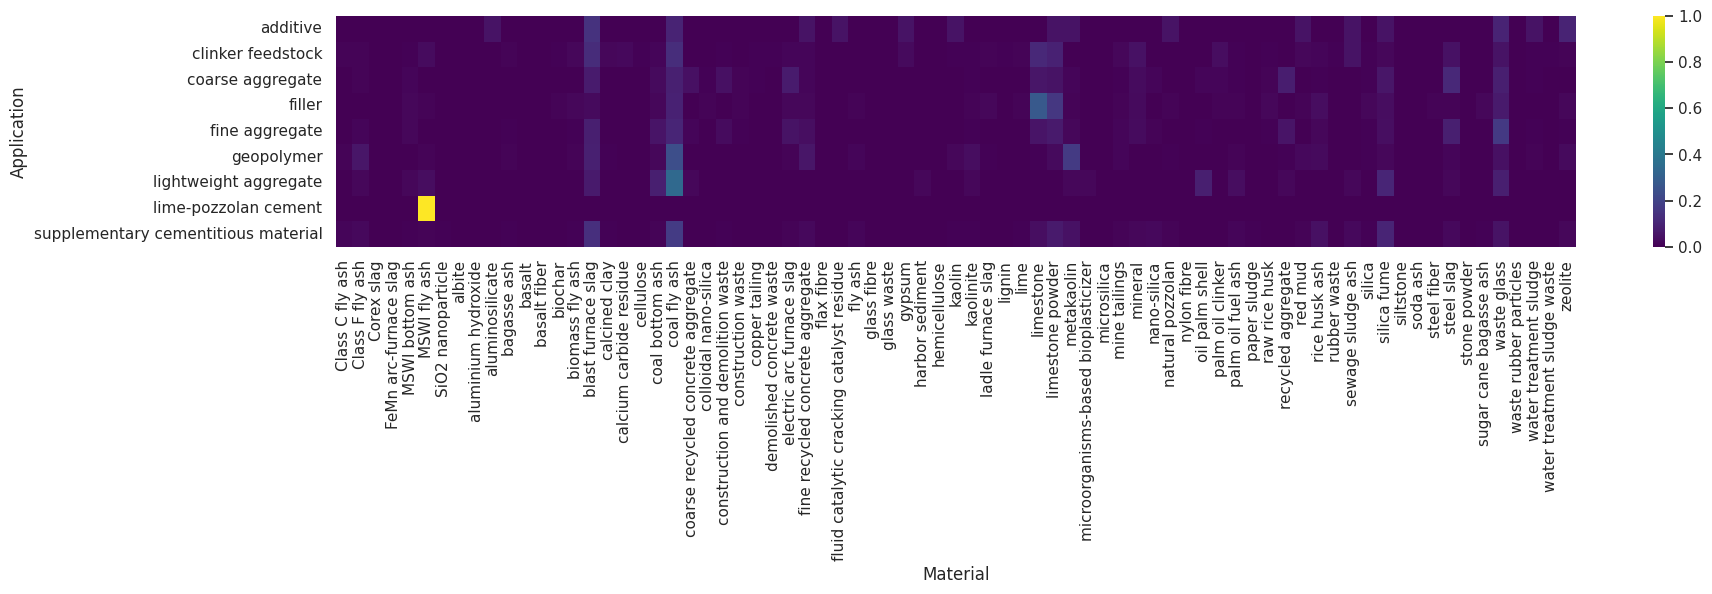

In [22]:
sns.set(rc={'figure.figsize':(20, 3)})

heatmap = sns.heatmap(mat_app_norm_forAPP, cmap="viridis", cbar_kws={'shrink': 1.0}, xticklabels=True, yticklabels=True)

fig = heatmap.get_figure()

fig.savefig("../Figs/new_mat_app_heatmap_normForAPP.jpg", bbox_inches="tight")

# MAT Similarity + MAT-APP Link Frequencies

## Read in MAT Jaccard

In [23]:
df_mat_jaccard = pd.read_csv(save_dir + "MAT_Jaccard.csv")

jaccard = df_mat_jaccard.pivot(index="material1", columns="material2", values="jaccard")

jaccard

material2,Class C fly ash,Class F fly ash,Corex slag,FeMn arc-furnace slag,MSWI bottom ash,MSWI fly ash,SiO2 nanoparticle,albite,aluminium hydroxide,aluminosilicate,...,soda ash,steel fiber,steel slag,stone powder,sugar cane bagasse ash,waste glass,waste rubber particles,water treatment sludge,water treatment sludge waste,zeolite
material1,,,,,,,,,,,,,,,,,,,,,
Class C fly ash,1.000000,0.029703,0.016129,0.031250,0.040404,0.027273,0.036145,0.015873,0.016129,0.030769,...,0.016129,0.029126,0.018868,0.013699,0.035714,0.012407,0.014706,0.045455,0.030769,0.031646
Class F fly ash,0.029703,1.000000,0.006757,0.013333,0.027174,0.020513,0.017751,0.006711,0.006757,0.013245,...,0.006757,0.015873,0.020270,0.006289,0.017647,0.016461,0.013072,0.028902,0.013245,0.020492
Corex slag,0.016129,0.006757,1.000000,0.166667,0.023256,0.018868,0.038462,0.250000,0.000000,0.142857,...,0.333333,0.021739,0.006410,0.071429,0.037037,0.002874,0.111111,0.031250,0.142857,0.009709
FeMn arc-furnace slag,0.031250,0.013333,0.166667,1.000000,0.044444,0.036364,0.071429,0.142857,0.166667,0.222222,...,0.166667,0.041667,0.012658,0.058824,0.033333,0.005714,0.083333,0.058824,0.100000,0.019048
MSWI bottom ash,0.040404,0.027174,0.023256,0.044444,1.000000,0.056180,0.030769,0.022727,0.023256,0.043478,...,0.023256,0.035714,0.036842,0.018519,0.046154,0.020997,0.020408,0.073529,0.066667,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
waste glass,0.012407,0.016461,0.002874,0.005714,0.020997,0.012690,0.008130,0.002865,0.002874,0.008571,...,0.002874,0.010309,0.016194,0.002786,0.010840,1.000000,0.005666,0.018868,0.008571,0.018141
waste rubber particles,0.014706,0.013072,0.111111,0.083333,0.020408,0.016949,0.031250,0.100000,0.000000,0.076923,...,0.111111,0.019231,0.012422,0.050000,0.030303,0.005666,1.000000,0.054054,0.076923,0.018519
water treatment sludge,0.045455,0.028902,0.031250,0.058824,0.073529,0.037500,0.037037,0.030303,0.031250,0.088235,...,0.031250,0.027027,0.033333,0.023256,0.036364,0.018868,0.054054,1.000000,0.088235,0.047244


## Multiply Jaccard Matrix and Col-normalized MAT-APP Count Heatmap Matrix

<AxesSubplot:xlabel='Material', ylabel='Application'>

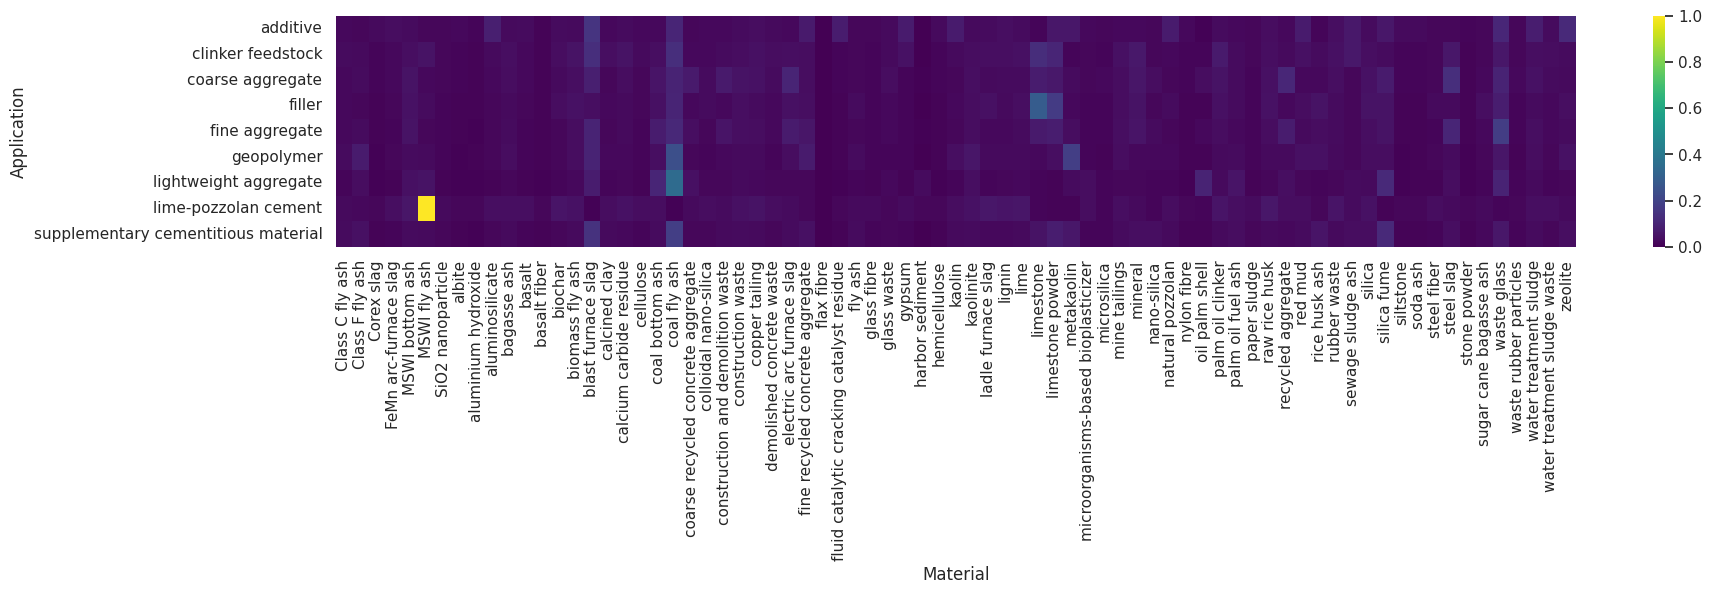

In [25]:
new_mat_app = np.matmul(mat_app_norm_forAPP.to_numpy(), jaccard.to_numpy())

df_new_mat_app = mat_app_norm_forAPP.copy(deep=True)
df_new_mat_app.iloc[:,:] = new_mat_app

sns.set(rc={'figure.figsize':(20, 3)})

sns.heatmap(df_new_mat_app, cmap="viridis", cbar_kws={'shrink': 1.0}, xticklabels=True, yticklabels=True)

## Use MAT-APP Heatmap Differences to Reflect Potential New Links

### Direct Subtraction

<AxesSubplot:xlabel='Material', ylabel='Application'>

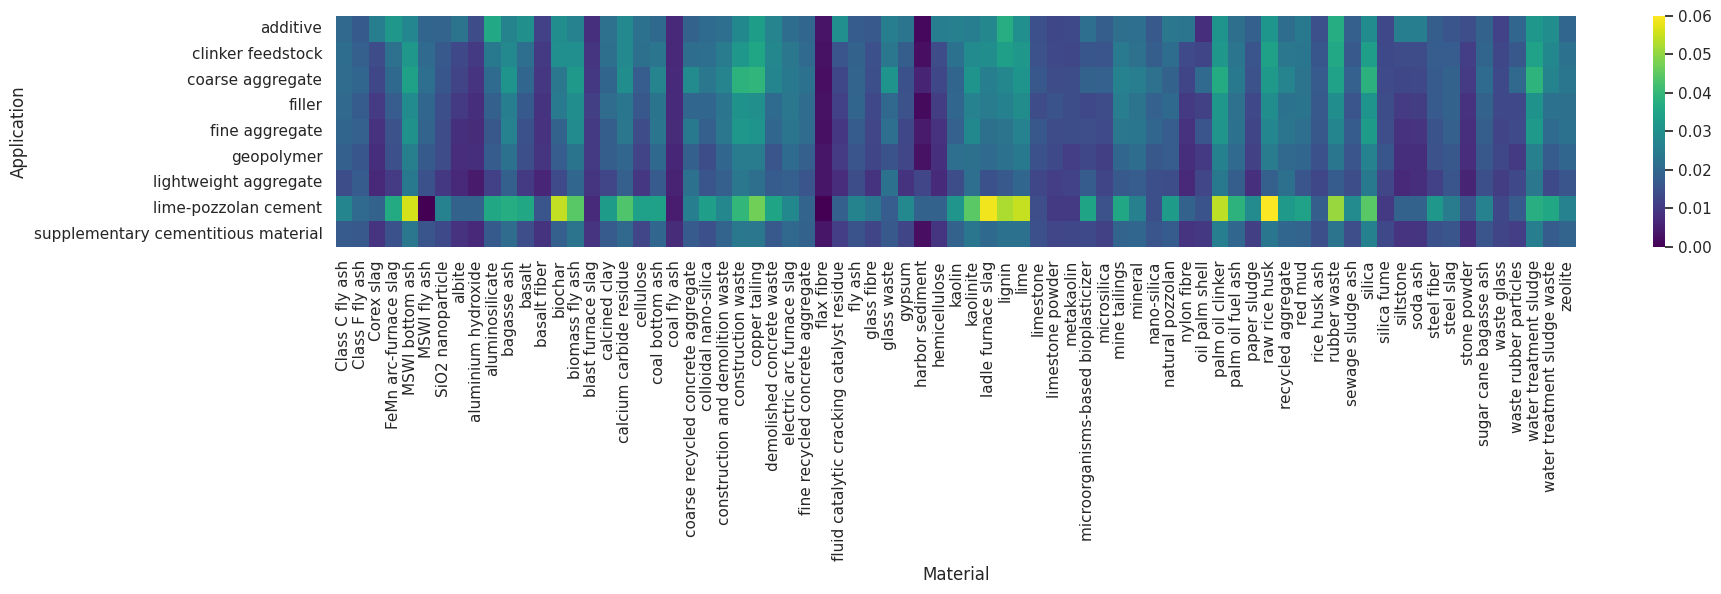

In [27]:
heatmap_diff = df_new_mat_app - mat_app_norm_forAPP

sns.heatmap(heatmap_diff, cmap="viridis", cbar_kws={'shrink': 1.0}, vmax=0.06, xticklabels=True, yticklabels=True)


### Only Focus on Previously "0" Links

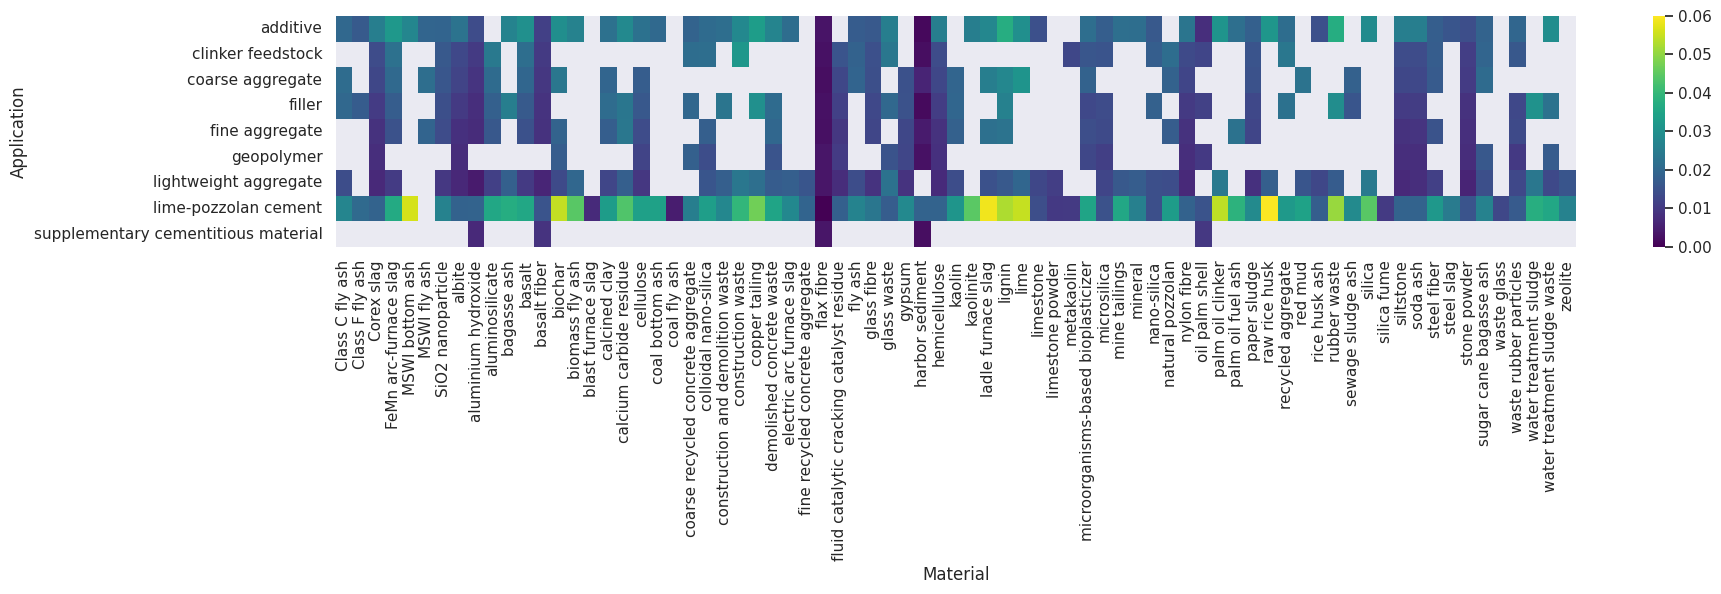

In [29]:
heatmap_diff_at0 = heatmap_diff[mat_app_norm_forAPP == 0]

sns.set(rc={'figure.figsize':(20, 3)})

heatmap = sns.heatmap(heatmap_diff_at0, cmap="viridis", cbar_kws={'shrink': 1.0}, vmax=0.06, 
            xticklabels=True, yticklabels=True)


fig = heatmap.get_figure()

fig.savefig("../Figs/Graph/new_mat_app_link_pred_matSim.jpg", bbox_inches="tight")

# Katz Measure

In [30]:
adj_matrix = nx.to_numpy_array(G)

# Calculate the eigenvalues using numpy
eigenvalues = np.linalg.eigvals(adj_matrix)

In [31]:
lambda_largest = float(sorted(eigenvalues, reverse=True)[0])

alpha = 0.95 * 1/lambda_largest

print("alpha = {}".format(alpha))

alpha = 0.0009896815827220044


/tmp/ipykernel_27478/1280599074.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  lambda_largest = float(sorted(eigenvalues, reverse=True)[0])


In [32]:
katz_centrality = nx.katz_centrality_numpy(G, alpha=alpha, weight="weight")

## Locate MAT and APP Nodes

In [33]:
mat_nodes = [node for node, data in G.nodes(data=True) if data.get("node_type") == "material"]
app_nodes = [node for node, data in G.nodes(data=True) if data.get("node_type") == "application"]

In [34]:
mat_katz = []
app_katz = []
for node, katz in sorted(katz_centrality.items()):
    if node in mat_nodes:
        mat_katz.append(
            {
                "material": node,
                "katz": katz
            })
    if node in app_nodes:
        app_katz.append(
            {
                "application": node,
                "katz": katz
            })

## Calculate Katz Product to Reflect Link Importance

In [35]:
mat_app_katz = pd.DataFrame.from_records(mat_katz).merge(pd.DataFrame.from_records(app_katz), 
                                                         how="cross").rename(columns={"katz_x": "katz_mat",
                                                                                      "katz_y": "katz_app"})

removed = ["aggregate", "pore forming agent", "reinforced fibre", "superplasticizer"]
mat_app_katz = mat_app_katz[(~mat_app_katz["application"].isin(removed))]

mat_app_katz["katz_product"] = mat_app_katz["katz_mat"] * mat_app_katz["katz_app"]

mat_app_katz

,material,katz_mat,application,katz_app,katz_product
0,Class C fly ash,0.029244,additive,0.010213,0.000299
2,Class C fly ash,0.029244,clinker feedstock,0.033695,0.000985
3,Class C fly ash,0.029244,coarse aggregate,0.017465,0.000511
4,Class C fly ash,0.029244,filler,0.019765,0.000578
5,Class C fly ash,0.029244,fine aggregate,0.040743,0.001191
...,...,...,...,...,...
967,zeolite,0.039170,fine aggregate,0.040743,0.001596
968,zeolite,0.039170,geopolymer,0.135787,0.005319
969,zeolite,0.039170,lightweight aggregate,0.017724,0.000694
970,zeolite,0.039170,lime-pozzolan cement,0.007956,0.000312


In [36]:
mat_app_katz.to_csv(save_dir + "new_MAT_APP_katz.csv", index=False)

## Link Prediction

### Direct Showing Katz Product

<AxesSubplot:xlabel='material', ylabel='application'>

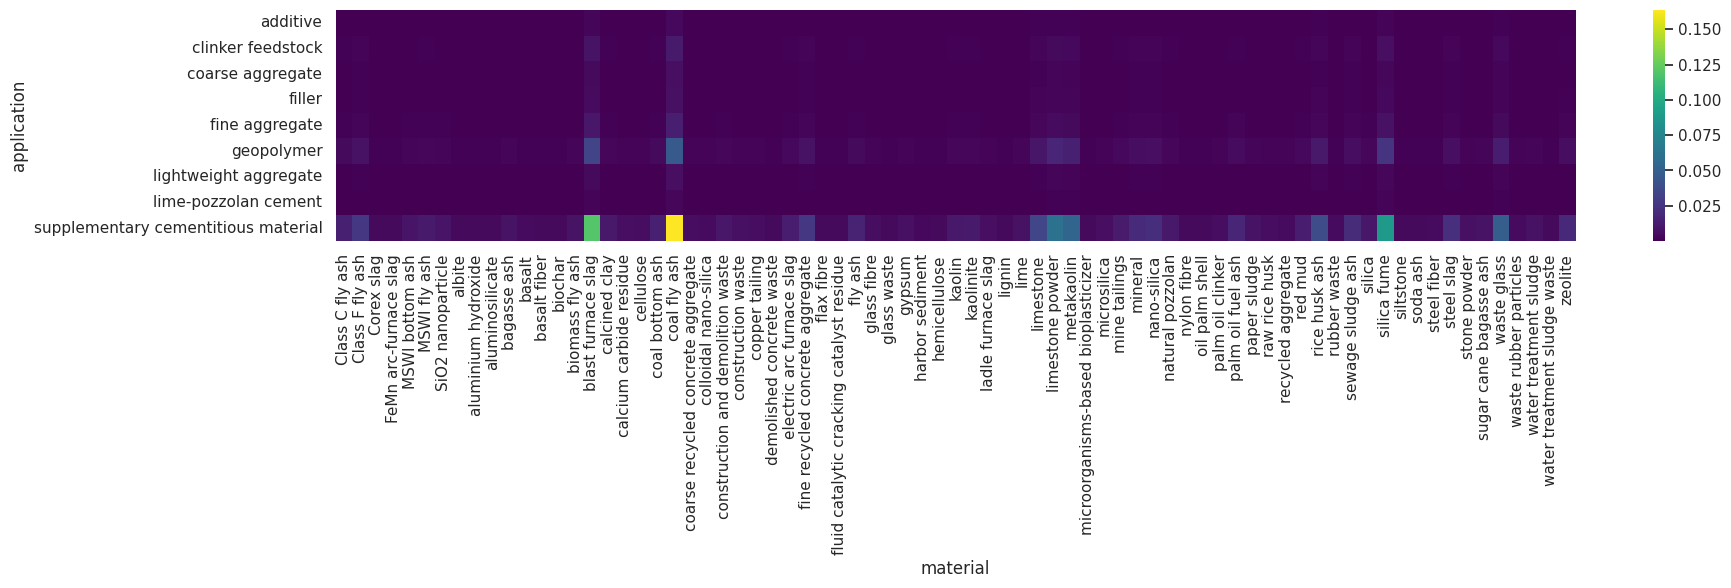

In [38]:
import seaborn as sns

katz_data = mat_app_katz.pivot(index="application", columns="material", values="katz_product")

sns.set(rc={'figure.figsize':(20, 3)})

sns.heatmap(katz_data, cmap="viridis", cbar_kws={'shrink': 1.0}, xticklabels=True, yticklabels=True)

### Only Focus on Previously "0" Entries

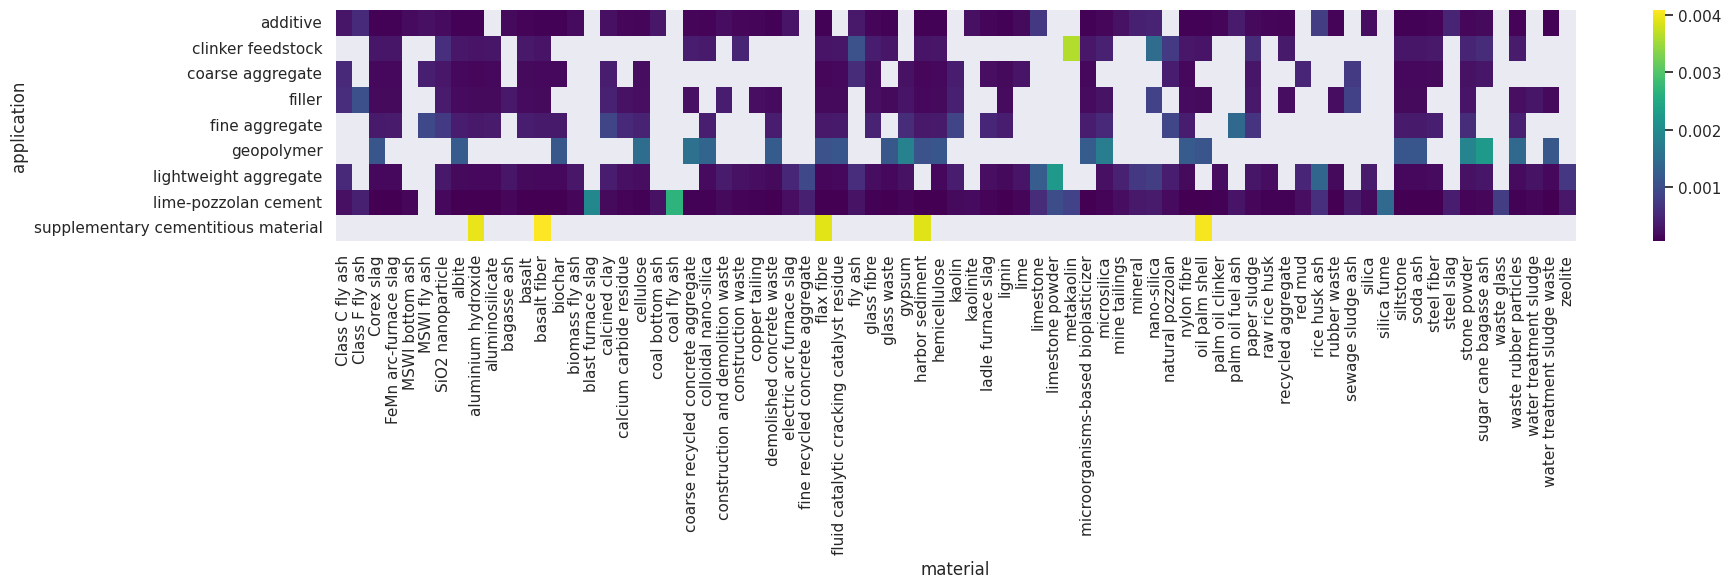

In [39]:
katz_data_at0 = katz_data[mat_app_norm_forAPP == 0]

sns.set(rc={'figure.figsize':(20, 3)})

heatmap = sns.heatmap(katz_data_at0, cmap="viridis", cbar_kws={'shrink': 1.0}, xticklabels=True, yticklabels=True)

fig = heatmap.get_figure()

fig.savefig("../Figs/Graph/new_mat_app_link_pred_Katz.jpg", bbox_inches="tight")